In [ ]:
# Instalación PySpark en caso de no estar Instalado
!pip install -q pyspark

In [16]:
#Crear sesión en Apache Spark - SparkSession
from pyspark.sql import SparkSession

#Crear sesión
spark = SparkSession.builder.appName("ProyectoMetroSantiago").config("spark.executor.memory","1g").config("spark.driver.memory","1g").config("spark.sql.shuffle.partitions","2").getOrCreate()

In [17]:
# Cargar los datos del CSV a un DF
df = spark.read.csv("metro_santiago.csv",header=True,inferSchema=True)

In [18]:
df.show()

+---------+-----+--------------+--------------------+----------------+-------------------+
|id_evento|linea|      estacion|      tipo_incidente|duracion_minutos|               hora|
+---------+-----+--------------+--------------------+----------------+-------------------+
|        1|   L2|      Lo Prado|     Falla eléctrica|              15|2025-08-26 11:45:00|
|        2|   L5|   Irarrázaval|          Evacuación|              15|2025-08-26 20:00:00|
|        3|   L4|     San Pablo|     Falla eléctrica|              25|2025-08-26 19:00:00|
|        4|   L1|      Lo Prado|     Falla eléctrica|              30|2025-08-26 05:45:00|
|        5|   L3|   Irarrázaval|     Falla eléctrica|              20|2025-08-26 08:00:00|
|        6|   L2|    Los Leones|       Mantenimiento|              30|2025-08-26 17:00:00|
|        7|   L3|         Ñuñoa|       Mantenimiento|               5|2025-08-26 12:30:00|
|        8|   L1|    Los Héroes|     Falla eléctrica|              30|2025-08-26 08:30:00|

In [19]:
df.printSchema()

root
 |-- id_evento: integer (nullable = true)
 |-- linea: string (nullable = true)
 |-- estacion: string (nullable = true)
 |-- tipo_incidente: string (nullable = true)
 |-- duracion_minutos: integer (nullable = true)
 |-- hora: timestamp (nullable = true)



In [20]:
df.describe().show()

+-------+------------------+-----+---------+--------------+-----------------+
|summary|         id_evento|linea| estacion|tipo_incidente| duracion_minutos|
+-------+------------------+-----+---------+--------------+-----------------+
|  count|                50|   50|       50|            50|               50|
|   mean|              25.5| NULL|     NULL|          NULL|             17.8|
| stddev|14.577379737113251| NULL|     NULL|          NULL|7.964205637009345|
|    min|                 1|   L1|Baquedano|    Evacuación|                5|
|    max|                50|   L6|    Ñuñoa|       Retraso|               30|
+-------+------------------+-----+---------+--------------+-----------------+



In [21]:
df.select("tipo_incidente").distinct().show()

+--------------------+
|      tipo_incidente|
+--------------------+
|     Falla eléctrica|
|          Evacuación|
|       Mantenimiento|
|Interrupción de s...|
|             Retraso|
+--------------------+



In [24]:
#Consultas al DF - Filtrar información (TRANSFORMACIONES)
df.filter(df.tipo_incidente == "Falla eléctrica").select("estacion","tipo_incidente").show(5)

+-----------+---------------+
|   estacion| tipo_incidente|
+-----------+---------------+
|   Lo Prado|Falla eléctrica|
|  San Pablo|Falla eléctrica|
|   Lo Prado|Falla eléctrica|
|Irarrázaval|Falla eléctrica|
| Los Héroes|Falla eléctrica|
+-----------+---------------+
only showing top 5 rows



In [23]:
# Aplicar funcionalidades de consulta de datos agrupados y con conteo
df.groupBy("tipo_incidente").count().orderBy("count",ascending = False).show()

+--------------------+-----+
|      tipo_incidente|count|
+--------------------+-----+
|     Falla eléctrica|   14|
|       Mantenimiento|   12|
|Interrupción de s...|   11|
|          Evacuación|    8|
|             Retraso|    5|
+--------------------+-----+



In [12]:
# Aplicar funcionalidades avanzadas de consulta en DFs
from pyspark.sql.functions import col,desc,count

df.groupBy("estación").agg(count("tipo_incidente").alias("total_incidentes")).filter(col("total_incidentes") > 3).orderBy(desc("total_incidentes")).show()

+-----------+----------------+
|   estación|total_incidentes|
+-----------+----------------+
| Los Héroes|               6|
|  Baquedano|               6|
|Irarrázaval|               4|
+-----------+----------------+



In [25]:
# Trabajar con optimizadores = CATALYST
#Optimizador que organiza por mi el plan lógico de ejecución en PySpark
df.createOrReplaceTempView("incidentes")

spark.sql("""
  SELECT estacion, COUNT(*) as total
  FROM incidentes
  WHERE tipo_incidente = 'Evacuación'
  GROUP BY estacion
  ORDER BY total DESC
  LIMIT 5
""").show()

+-------------+-----+
|     estacion|total|
+-------------+-----+
|    Santa Ana|    2|
|  Irarrázaval|    2|
|  Plaza Egaña|    1|
|   Los Héroes|    1|
|Los Dominicos|    1|
+-------------+-----+



In [27]:
# Trabajar con optimizadores = TUNGSTEN
spark.sql("""
  SELECT linea, COUNT(*) as cantidad
  FROM incidentes
  GROUP BY linea
  ORDER BY cantidad DESC
  """).show()

+-----+--------+
|linea|cantidad|
+-----+--------+
|   L5|      13|
|   L3|       9|
|  L4A|       9|
|   L1|       8|
|   L2|       5|
|   L4|       5|
|   L6|       1|
+-----+--------+



In [29]:
# fUNCIONES DEFINIDAS POR UNO COMO USUARIO - pyspark - sparksql
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def clasificar_tipo(tipo):
  if "técnica" in tipo.lower():
    return "Técnica"
  else:
    return "Otro"

#Registramos la función como Función SQL = udf() PySpark SQL
clasificar_udf = udf(clasificar_tipo, StringType())

# Aplicamos esa función al DF generando una columna nueva llamada categoria
df_udf = df.withColumn("categoria", clasificar_udf(df["tipo_incidente"]))
df_udf.select("tipo_incidente", "categoria").show(5)

+---------------+---------+
| tipo_incidente|categoria|
+---------------+---------+
|Falla eléctrica|     Otro|
|     Evacuación|     Otro|
|Falla eléctrica|     Otro|
|Falla eléctrica|     Otro|
|Falla eléctrica|     Otro|
+---------------+---------+
only showing top 5 rows



# Ejercicio de la clase

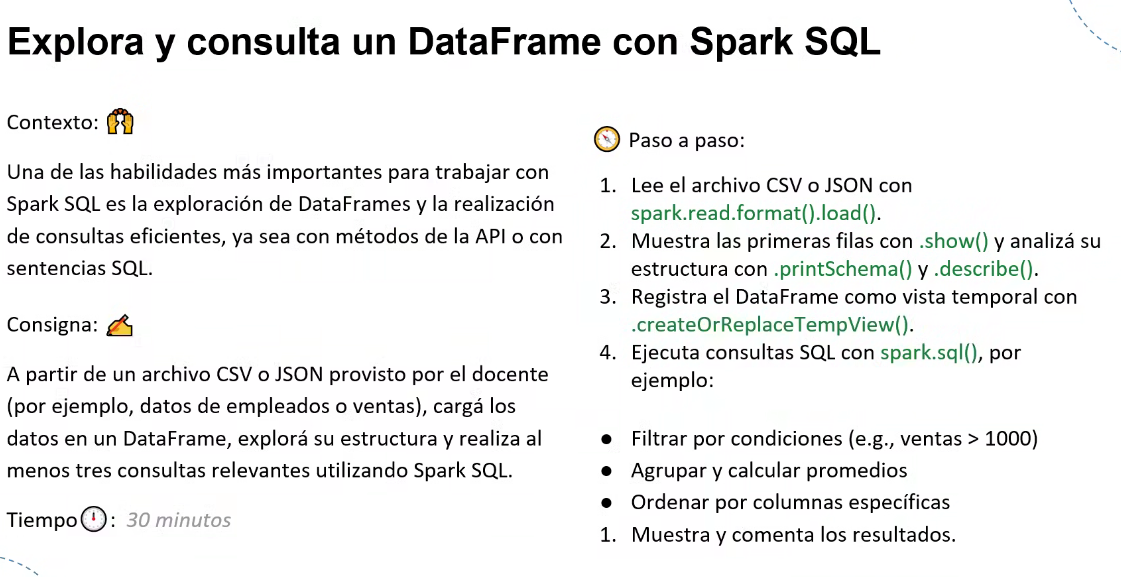

In [31]:
#Crear sesión
spark = SparkSession.builder.appName("HospitalSantiago").config("spark.executor.memory","1g").config("spark.driver.memory","1g").config("spark.sql.shuffle.partitions","2").getOrCreate()

In [32]:
# Cargar los datos del CSV a un DF
df = spark.read.csv("ejercicio_hospital_santiago.csv",header=True,inferSchema=True)

In [33]:
df.show()

+-----------+--------+---------+----+----+----------------+-----------------+-------------+---------------------+--------------------+-----------+---------------+-----------+
|paciente_id|  nombre| apellido|edad|sexo|          comuna| servicio_clinico|fecha_ingreso|diagnostico_principal|dias_hospitalizacion|costo_total|medico_tratante|estado_alta|
+-----------+--------+---------+----+----+----------------+-----------------+-------------+---------------------+--------------------+-----------+---------------+-----------+
|          1|   María| González|  45|   F|        Santiago| Medicina Interna|   2024-01-15| Hipertensión arte...|                   3|     450000|  Dr. Rodríguez|Alta médica|
|          2|    Juan|    Pérez|  67|   M|     Providencia|      Cardiología|   2024-01-18| Infarto agudo mio...|                   7|    1200000|      Dr. Silva|Alta médica|
|          3|  Carmen|    López|  34|   F|      Las Condes|      Ginecología|   2024-01-20|         Parto normal|            

In [35]:
df.printSchema()

root
 |-- paciente_id: integer (nullable = true)
 |-- nombre: string (nullable = true)
 |-- apellido: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- sexo: string (nullable = true)
 |-- comuna: string (nullable = true)
 |-- servicio_clinico: string (nullable = true)
 |-- fecha_ingreso: date (nullable = true)
 |-- diagnostico_principal: string (nullable = true)
 |-- dias_hospitalizacion: integer (nullable = true)
 |-- costo_total: integer (nullable = true)
 |-- medico_tratante: string (nullable = true)
 |-- estado_alta: string (nullable = true)



In [36]:
df.describe()

DataFrame[summary: string, paciente_id: string, nombre: string, apellido: string, edad: string, sexo: string, comuna: string, servicio_clinico: string, diagnostico_principal: string, dias_hospitalizacion: string, costo_total: string, medico_tratante: string, estado_alta: string]

In [37]:
# Trabajar con optimizadores = CATALYST
#Optimizador que organiza por mi el plan lógico de ejecución en PySpark
df.createOrReplaceTempView("costos")

In [53]:
spark.sql("""
  SELECT nombre, apellido, costo_total, comuna
  FROM costos
  WHERE costo_total > 400000
  ORDER BY costo_total DESC
  """).show()

+--------+----------+-----------+-----------------+
|  nombre|  apellido|costo_total|           comuna|
+--------+----------+-----------+-----------------+
|   Jorge|  Marchant|    4500000|             Buin|
|Carolina|     Bravo|    4200000|             Buin|
|  Silvia|  Riquelme|    3800000|      San Joaquín|
|   Elena|    Moreno|    3500000|       La Florida|
|  Andrea|    Loyola|    3100000|    Independencia|
| Soledad|   Ramírez|    2800000|        Cerrillos|
|  Felipe|    Espejo|    2800000|        Melipilla|
| Viviana| Maldonado|    2650000|  Calera de Tango|
|Fernando|   Briceño|    2200000| Estación Central|
|   Pedro|  Martínez|    2100000|            Ñuñoa|
|Cristián|    Romero|    1680000|        Talagante|
| Beatriz|   Herrera|    1450000| Estación Central|
| Roberto|    Flores|    1300000|    Independencia|
|    Juan|     Pérez|    1200000|      Providencia|
|  Hernán|Villalobos|    1200000|        La Granja|
|  Mónica|     Ulloa|    1200000|            Paine|
| Antonio|  

In [47]:
spark.sql("""
  SELECT AVG(costo_total) as promedio_costo, comuna, AVG(edad) as promedio_edad
  FROM costos
  GROUP BY comuna
  ORDER BY AVG(costo_total) DESC
  """).show()

+--------------+-----------------+-------------+
|promedio_costo|           comuna|promedio_edad|
+--------------+-----------------+-------------+
|     4350000.0|             Buin|         57.0|
|     2650000.0|  Calera de Tango|         50.0|
|     2390000.0|      San Joaquín|         53.0|
|     2200000.0|    Independencia|         56.5|
|     2110000.0|       La Florida|         55.0|
|     1825000.0| Estación Central|         63.5|
|     1725000.0|        Cerrillos|         54.0|
|     1690000.0|        Melipilla|         51.0|
|     1680000.0|        Talagante|         74.0|
|     1190000.0|            Ñuñoa|         55.5|
|     1150000.0|      María Pinto|         58.0|
|     1045000.0|            Paine|         47.0|
|      965000.0|      Cerro Navia|         63.5|
|      840000.0|      Providencia|         52.0|
|      820000.0|        San Pedro|         64.0|
|      780000.0|    Isla de Maipo|         49.0|
|      750000.0|        San Ramón|         60.0|
|      710000.0|    

In [49]:
spark.sql("""
  SELECT diagnostico_principal, COUNT(diagnostico_principal) as Num_Diagnostico
  FROM costos
  GROUP BY diagnostico_principal
  ORDER BY Num_Diagnostico DESC
  """).show()

+---------------------+---------------+
|diagnostico_principal|Num_Diagnostico|
+---------------------+---------------+
| Hipertensión arte...|              1|
|         Parto normal|              1|
| Accidente cerebro...|              1|
|       Úlcera péptica|              1|
|    Arritmia cardíaca|              1|
|              Cesárea|              1|
|  Esguince de tobillo|              1|
|    Gastritis crónica|              1|
|            Psoriasis|              1|
|     Bronquitis aguda|              1|
|           Tendinitis|              1|
|            Hepatitis|              1|
|       Demencia senil|              1|
|           Faringitis|              1|
|   Infección urinaria|              1|
|              Migraña|              1|
|          Mastectomía|              1|
| Fractura de claví...|              1|
|       Quiste ovárico|              1|
|            Sinusitis|              1|
+---------------------+---------------+
only showing top 20 rows



In [50]:
spark.sql("""
  SELECT sexo, COUNT(sexo) as Cantidad_genero
  FROM costos
  GROUP BY sexo
  ORDER BY Cantidad_genero DESC
  """).show()

+----+---------------+
|sexo|Cantidad_genero|
+----+---------------+
|   F|             40|
|   M|             40|
+----+---------------+



In [55]:
spark.sql("""
  SELECT edad, nombre, apellido,
  CASE
      WHEN edad < 30 THEN 'Jovenes'
      WHEN edad BETWEEN 30 AND 50 THEN 'Adultos'
      ELSE 'Viejovenes'
  END AS Categoria_edad
  FROM costos
  """).show()

+----+--------+---------+--------------+
|edad|  nombre| apellido|Categoria_edad|
+----+--------+---------+--------------+
|  45|   María| González|       Adultos|
|  67|    Juan|    Pérez|    Viejovenes|
|  34|  Carmen|    López|       Adultos|
|  78|   Pedro| Martínez|    Viejovenes|
|  29|     Ana|  Jiménez|       Jovenes|
|  52|    Luis|Hernández|    Viejovenes|
|  41|    Rosa|     Díaz|       Adultos|
|  36|  Carlos|     Ruiz|       Adultos|
|  58|   Elena|   Moreno|    Viejovenes|
|  43|   Jorge|  Sánchez|       Adultos|
|  31|Patricia|     Vega|       Adultos|
|  65| Roberto|   Flores|    Viejovenes|
|  27| Claudia|   Castro|       Jovenes|
|  71|  Miguel|    Reyes|    Viejovenes|
|  39|  Gloria|    Muñoz|       Adultos|
|  56|Fernando|    Silva|    Viejovenes|
|  48|  Mónica|    Parra|       Adultos|
|  33|  Andrés|   Torres|       Adultos|
|  62| Beatriz|  Herrera|    Viejovenes|
|  25|  Daniel|Contreras|       Jovenes|
+----+--------+---------+--------------+
only showing top

In [59]:
spark.sql("""
  SELECT medico_tratante, COUNT(medico_tratante) Cant_tratamientos, SUM(costo_total) Total_lucas
  FROM costos
  GROUP BY medico_tratante
  ORDER BY Total_lucas DESC
  """).show()

+---------------+-----------------+-----------+
|medico_tratante|Cant_tratamientos|Total_lucas|
+---------------+-----------------+-----------+
|    Dr. Mendoza|                6|   20050000|
|      Dr. Silva|               10|   12940000|
|  Dr. Rodríguez|               19|   11280000|
|     Dr. Torres|                7|    9060000|
|     Dr. Vargas|               12|    5320000|
|    Dr. Aguirre|                6|    5180000|
|     Dr. Castro|                7|    5010000|
|   Dra. Morales|                7|    3260000|
|     Dra. Rojas|                6|    2100000|
+---------------+-----------------+-----------+

